# California Housing Prices (circa 1990)

We analyze the California Housing Prices dataset from the [StatLib repository](http://lib.stat.cmu.edu/datasets/), which is used for Aurélien Géron's recent Machine Learning book. This dataset is based on data from the 1990 California census. It is not exactly recent (a nice house in the Bay Area was still affordable at the time), but it has many qualities for learning, so we will pretend it is recent data. For this notebook, we have added a categorical attribute and removed a few features.

Block groups are the smallest geographical unit for which the US Census Bureau publishes sample data (a block group typically has a popula‐ tion of 600 to 3,000 people). We will call them “districts” for short.


* The original dataset appeared in R. Kelley Pace and Ronald Barry, “Sparse Spatial Autoregressions,” Statistics & Probability Letters 33, no. 3 (1997): 291–29


## Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20.

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "../images")
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [2]:
import pandas as pd

HOUSING_PATH = os.path.join("../data")

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [3]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [4]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [5]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [6]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

Saving figure attribute_histogram_plots


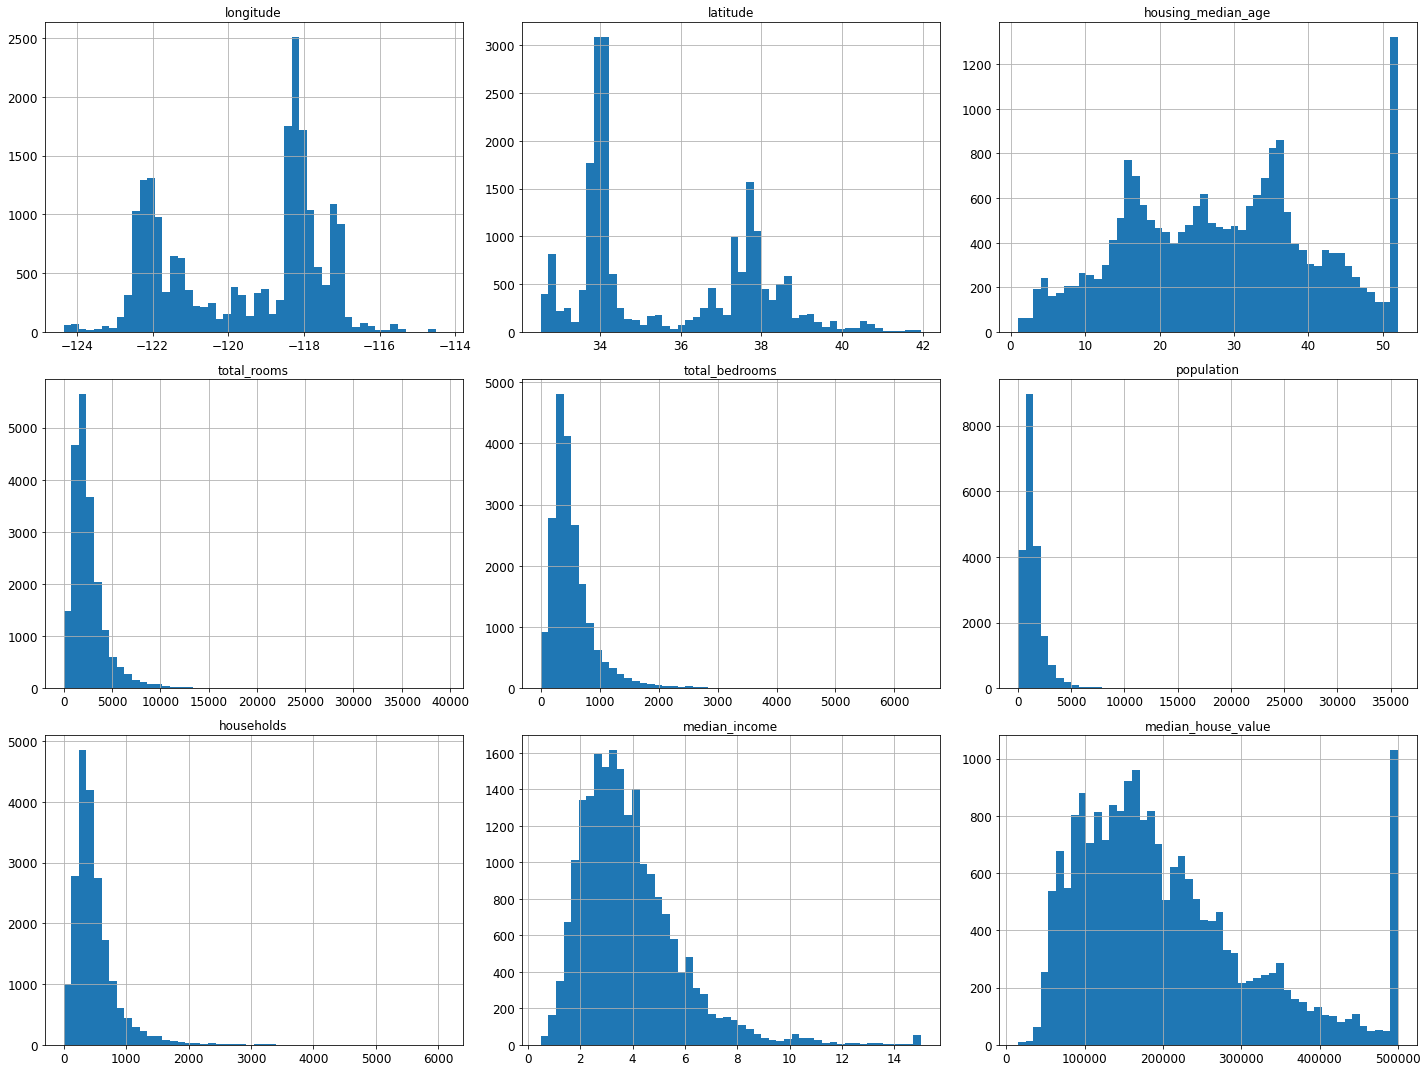

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20,15))
save_fig("attribute_histogram_plots")
plt.show()


There are a few things you might notice in these histograms:
1. First, the median income attribute does not look like it is expressed in US dollars (USD). After checking with the team that collected the data, you are told that the data has been scaled and capped at 15 (actually, 15.0001) for higher median incomes, and at 0.5 (actually, 0.4999) for lower median incomes. The numbers represent roughly tens of thousands of dollars (e.g., 3 actually means about $30,000). Working with preprocessed attributes is common in Machine Learning, and it is not necessarily a problem, but you should try to understand how the data was computed.

2. The housing median age and the median house value were also capped. The latter may be a serious problem since it is your target attribute (your labels). Your Machine Learning algorithms may learn that prices never go beyond that limit. You need to check with your business partners to see if this is a problem or not. If they tell you that they need precise predictions even beyond $500K, then you have two options:

    * Collect proper labels for the districts whose labels were capped.
    * Remove those districts from the training set (and also from the test set, since your system should not be evaluated poorly if it predicts values beyond $500,000).


3. These attributes have very different scales. 

4. Finally, many histograms are tail-heavy: they extend much farther to the right of
the median than to the left. This may make it a bit harder for some Machine
Learning algorithms to detect patterns. We will try transforming these attributes
later on to have more bell-shaped distributions.



## Create a Test Set

It may sound strange to voluntarily set aside part of the data at this stage. After all, you have only taken a quick glance at the data, and surely you should learn a whole lot more about it before you decide what algorithms to use, right? This is true, but your brain is an amazing pattern detection system, which means that it is highly prone to overfitting: if you look at the test set, you may stumble upon some seemingly interesting pattern in the test data that leads you to select a particular kind of Machine Learning model. When you estimate the generalization error using the test set, your estimate will be too optimistic, and you will launch a system that will not perform as well as expected. This is called data snooping bias.

Creating a test set is theoretically simple: pick some instances randomly, typically 20% of the dataset (or less if your dataset is very large), and set them aside:


In [8]:
from sklearn.model_selection import train_test_split

In [9]:
X = housing

In [10]:
X_train, X_test = \
    train_test_split(X, test_size=0.2, random_state=0)

### Stratified Sampling

So far we have considered purely random sampling methods. This is generally fine if your dataset is large enough (especially relative to the number of attributes), but if it is not, you run the risk of introducing a significant sampling bias. When a survey company decides to call 1,000 people to ask them a few questions, they don’t just pick 1,000 people randomly in a phone book. They try to ensure that these 1,000 people are representative of the whole population. 

For example, the US population is 51.3% females and 48.7% males, so a well-conducted survey in the US would try to maintain this ratio in the sample: 513 female and 487 male. This is called stratiied sampling: the population is divided into homogeneous subgroups called strata, and the right number of instances are sampled from each stratum to guarantee that the test set is representative of the overall population. If the people running the survey used purely random sampling, there would be about a 12% chance of sampling a skewed test set

Suppose you chatted with experts who told you that the median income is a very important attribute to predict median housing prices. You may want to ensure that the test set is representative of the various categories of incomes in the whole dataset. Since the median income is a continuous numerical attribute, you first need to create an income category attribute. 

In [11]:
housing.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity'],
      dtype='object')

<AxesSubplot:>

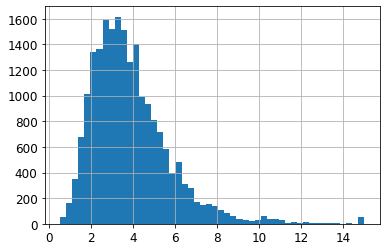

In [12]:
housing['median_income'].hist(bins=50)

Let’s look at the median income histogram more closely: most median income values are clustered around 1.5 to 6 (i.e., $15,000–$60,000), but some median incomes go far beyond 6. It is important to have a sufficient number of instances in your dataset for each stratum, or else the estimate of a stratum’s importance may be biased. This means that you should not have too many strata, and each stratum should be large enough. The following code uses the pd.cut() function to create an income category attribute with five categories (labeled from 1 to 5): category 1 ranges from 0 to 1.5 (i.e., less than $15,000), category 2 from 1.5 to 3, and so on:

In [13]:
housing["income_cat"] = pd.cut(housing['median_income'], \
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf], \
                               labels=[1,2,3,4,5])

<AxesSubplot:>

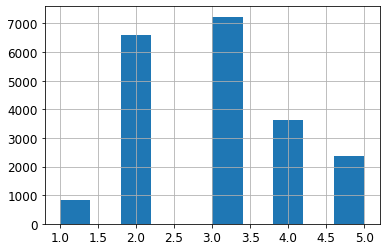

In [14]:
housing["income_cat"].hist()

We are now ready to do stratified sampling based on the income category. For this you can use Scikit-Learn’s StratifiedShuffleSplit class:


In [15]:
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0) 

In [16]:
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]     
    strat_test_set = housing.loc[test_index]

In [17]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114583
1    0.039729
Name: income_cat, dtype: float64

## Visualizing Data

Let’s create a copy so that we can play with it without harming the training set:


In [18]:
housing = strat_train_set.copy()

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

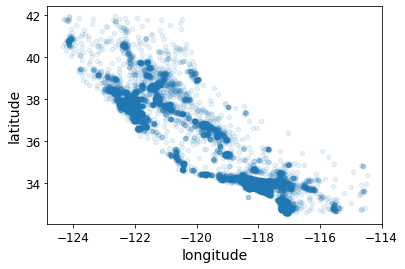

In [19]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)

Now let’s look at the housing prices.

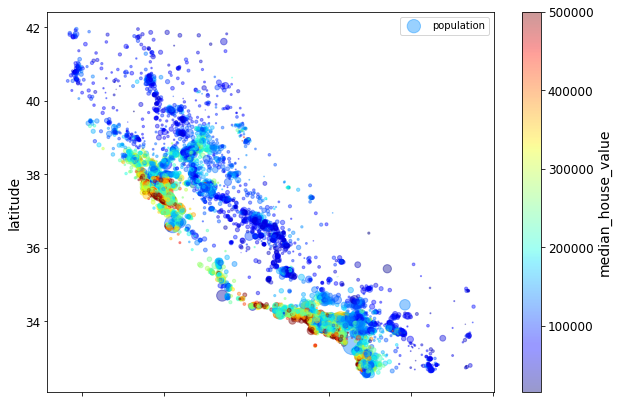

In [20]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
    s=housing["population"]/100, label="population", figsize=(10,7),
    c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
)
plt.legend()


The radius of each circle represents the district’s population (option s), and the color represents the price (option c). We will use a predefined color map (option cmap) called jet, which ranges from blue (low values) to red (high prices).

This image tells you that the housing prices are very much related to the location (e.g., close to the ocean) and to the population density, as you probably knew already. A clustering algorithm should be useful for detecting the main cluster and for adding new features that measure the proximity to the cluster centers. The ocean proximity attribute may be useful as well, although in Northern California the housing prices in coastal districts are not too high, so it is not a simple rule.


### Correlations

Let's understand correlations among the attributes of the CA housing dataset:

In [21]:
corr_matrix = housing.corr()

In [22]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688883
total_rooms           0.137469
housing_median_age    0.107144
households            0.069177
total_bedrooms        0.053544
population           -0.023797
longitude            -0.043236
latitude             -0.145570
Name: median_house_value, dtype: float64

The median house value tends to go up when the median income goes up. House prices have a slight tendency to go down when you go north.  

Let's use pandas to plot every numerical attribute against every other attributes.

array([[<AxesSubplot:xlabel='median_house_value', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='median_income', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='median_house_value'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='median_income'>,
        <AxesSubplot:xlabel='median_income', ylabel='median_income'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='median_income'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='median_income'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='median_income', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='total_rooms'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='housing_median_age'>,
        <AxesSubplot:xlabel='median_incom

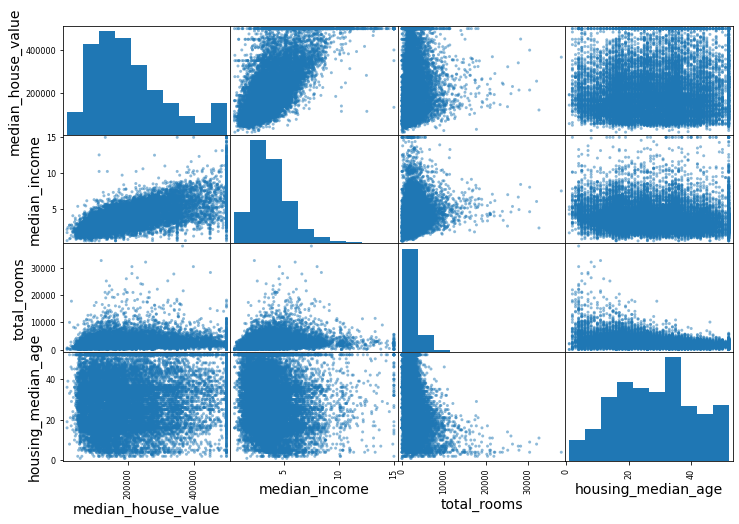

In [23]:
from pandas.plotting import scatter_matrix
attributes = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))

The most promising attribute to predict the median house value is the median income, so let’s zoom in on their correlation scatterplot:

<AxesSubplot:xlabel='median_income', ylabel='median_house_value'>

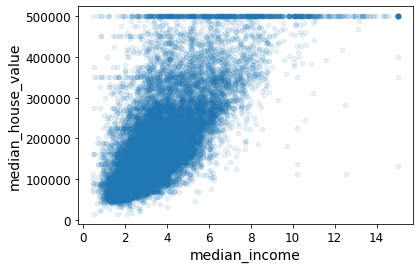

In [24]:
housing.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.1)

First, the correlation is indeed very strong; you can clearly see the upward trend, and the points are not too dispersed. Second, the price cap that we noticed earlier is clearly visible as a horizontal line at \\$500,000.  In addition, this plot reveals other less obvious straight lines: a horizontal line around \\$450,000, another around \\$350,000, perhaps one around \\$280,000, and a few more below that. You may want to try removing the corresponding districts to prevent your algorithms from learning to reproduce these data quirks. 

The total number of rooms in a district is not very useful if you don’t know how many households there are. What you really want is the number of rooms per household. Similarly, the total number of bedrooms by itself is not very useful: you probably want to compare it to the number of rooms. And the population per household also seems like an interesting attribute combination to look at. Let’s create these new attributes:

In [25]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"] 
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"] 
housing["population_per_household"]=housing["population"]/housing["households"]

In [26]:
corr_matrix = housing.corr()

In [27]:
corr_matrix["median_house_value"].sort_values(ascending=False)


median_house_value          1.000000
median_income               0.688883
rooms_per_household         0.157620
total_rooms                 0.137469
housing_median_age          0.107144
households                  0.069177
total_bedrooms              0.053544
population                 -0.023797
population_per_household   -0.026888
longitude                  -0.043236
latitude                   -0.145570
bedrooms_per_room          -0.255870
Name: median_house_value, dtype: float64

The new bedrooms_per_room attribute is much more correlated with the median house value than the total number of rooms or bedrooms. Apparently houses with a lower bedroom/room ratio tend to be more expensive. The number of rooms per household is also more informative than the total number of rooms in a district—obviously the larger the houses, the more expensive they are.


## Data Prep

Let’s  separate the predictors and the target labels, since we don’t necessarily want to apply the same transformations to the predictors and the target values (note that drop() creates a copy of the data and does not affect strat_train_set):

In [28]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

Most Machine Learning algorithms cannot work with missing features, so let’s create a few functions to take care of them. We saw earlier that the total_bedrooms attribute has some missing values, so let’s fix this. You have three options:
1. Get rid of the corresponding districts.
2. Get rid of the whole attribute.
3. Set the values to some value (zero, the mean, the median, etc.).

Let choose Option 3 to preserve as much of the training data as possible

In [29]:
median = housing["total_bedrooms"].median()
housing["total_bedrooms"].fillna(median, inplace=True)

Scikit-Learn provides a handy class to take care of missing values: SimpleImputer.
Here is how to use it. First, you need to create a SimpleImputer instance, specifying
that you want to replace each attribute’s missing values with the median of that
attribute:

In [30]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median") 

Since the median can only be computed on numerical attributes, you need to create a copy of the data without the text attribute ocean_proximity:


In [31]:
housing_num = housing.drop("ocean_proximity", axis=1)

Now you can fit the imputer instance to the training data using the fit() method:


In [32]:
imputer.fit(housing_num)

SimpleImputer(strategy='median')

The imputer has simply computed the median of each attribute and stored the result in its statistics_ instance variable. Only the total_bedrooms attribute had missing values, but we cannot be sure that there won’t be any missing values in new data after the system goes live, so it is safer to apply the imputer to all the numerical attributes:


In [33]:
imputer.statistics_

array([-118.49  ,   34.25  ,   29.    , 2128.5   ,  436.    , 1167.    ,
        410.    ,    3.5341,    3.    ])

Now you can use this “trained” imputer to transform the training set by replacing missing values with the learned medians:

In [34]:
X = imputer.transform(housing_num)

The result is a plain NumPy array containing the transformed features. If you want to put it back into a pandas DataFrame, it’s simple:

In [35]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns,
                          index=housing_num.index)

### Categorical Attributes: OrdinalEncoder

So far we have only dealt with numerical attributes, but now let’s look at text attributes. In this dataset, there is just one: the ocean_proximity attribute. Let’s look at its value for the first 10 instances:

In [36]:
housing_cat = housing[["ocean_proximity"]]
housing_cat.head(10) 

,ocean_proximity
10275,<1H OCEAN
20601,INLAND
20138,<1H OCEAN
18028,<1H OCEAN
16289,INLAND
4622,<1H OCEAN
15280,NEAR OCEAN
17228,<1H OCEAN
14268,NEAR OCEAN
1229,INLAND


It’s not arbitrary text: there are a limited number of possible values, each of which represents a category. So this attribute is a categorical attribute. Most Machine Learning algorithms prefer to work with numbers, so let’s convert these categories from text to numbers. For this, we can use Scikit-Learn’s OrdinalEncoder class:

In [37]:
from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder()

In [38]:
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)

In [39]:
housing_cat_encoded[:10]

array([[0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [4.],
       [0.],
       [4.],
       [1.]])

You can get the list of categories using the categories_ instance variable. It is a list containing a 1D array of categories for each categorical attribute (in this case, a list containing a single array since there is just one categorical attribute):

In [40]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

### Categorical Attributes: One-hot Encoder

One issue with this representation is that ML algorithms will assume that two nearby values are more similar than two distant values. This may be fine in some cases (e.g., for ordered categories such as “bad,” “average,” “good,” and “excellent”), but it is obvi‐ ously not the case for the ocean_proximity column (for example, categories 0 and 4 are clearly more similar than categories 0 and 1). To fix this issue, a common solution is to create one binary attribute per category: one attribute equal to 1 when the cate‐ gory is “<1H OCEAN” (and 0 otherwise), another attribute equal to 1 when the cate‐ gory is “INLAND” (and 0 otherwise), and so on. This is called one-hot encoding, because only one attribute will be equal to 1 (hot), while the others will be 0 (cold). The new attributes are sometimes called dummy attributes. Scikit-Learn provides a OneHotEncoder class to convert categorical values into one-hot vectors:



In [41]:
from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

Notice that the output is a SciPy sparse matrix, instead of a NumPy array. This is very useful when you have categorical attributes with thousands of categories. After one- hot encoding, we get a matrix with thousands of columns, and the matrix is full of 0s except for a single 1 per row. Using up tons of memory mostly to store zeros would be very wasteful, so instead a sparse matrix only stores the location of the nonzero elements. You can use it mostly like a normal 2D array, but if you really want to con‐ vert it to a (dense) NumPy array, just call the toarray() method:


In [42]:
housing_cat_1hot.toarray()

array([[1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.]])

In [43]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

### Representation & Embedding

If a categorical attribute has a large number of possible categories (e.g., country code, profession, species), then one-hot encoding will result in a large number of input features. This may slow down training and degrade performance. If this happens, you may want to replace the categorical input with useful numerical features related to the categories: for example, you could replace the ocean_proximity feature with the distance to the ocean (similarly, a country code could be replaced with the country’s population and GDP per capita). 

Alternatively, you could replace each category with a learnable, low-dimensional vector called an embedding. Each category’s representation would be learned during training. This is an example of representation learning (see Chapters 13 and 17 for more details).


### Custom Transformers

You can create your own transformer to work seamlessly with Scikit-Learn functionalities (such as pipelines).  Since Scikit-Learn relies on duck typing (not inher‐ itance), all you need to do is create a class and implement three methods:
   * `fit()` (returning self)
   * `transform()`
   * `fit_transform()`

Here is a small transformer class that adds a few combined attributes we discussed earlier:

In [46]:
from sklearn.base import BaseEstimator, TransformerMixin
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6
class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

In this example the transformer has one hyperparameter, add_bedrooms_per_room, set to True by default (it is often helpful to provide sensible defaults). This hyperparameter will allow you to easily find out whether adding this attribute helps the Machine Learning algorithms or not. More generally, you can add a hyperparameter to gate any data preparation step that you are not 100% sure about. The more you automate these data preparation steps, the more combinations you can automatically try out, making it much more likely that you will find a great combination (and sav‐ ing you a lot of time).

### Feature Scaling

One of the most important transformations you need to apply to your data is feature scaling. With few exceptions, Machine Learning algorithms don’t perform well when the input numerical attributes have very different scales. This is the case for the hous‐ ing data: the total number of rooms ranges from about 6 to 39,320, while the median incomes only range from 0 to 15. Note that scaling the target values is generally not required.

There are two common ways to get all attributes to have the same scale: min-max scaling and standardization.

#### Normalization
Min-max scaling (many people call this normalization) is the simplest: values are shif‐ ted and rescaled so that they end up ranging from 0 to 1. We do this by subtracting the min value and dividing by the max minus the min. Scikit-Learn provides a transformer called `MinMaxScaler` for this. It has a feature_range hyperparameter that lets you change the range if, for some reason, you don’t want 0–1.

#### Standardization
Standardization is different: first it subtracts the mean value (so standardized values always have a zero mean), and then it divides by the standard deviation so that the resulting distribution has unit variance. Unlike min-max scaling, standardization does not bound values to a specific range, which may be a problem for some algo‐ rithms (e.g., neural networks often expect an input value ranging from 0 to 1). How‐ ever, standardization is much less affected by outliers. For example, suppose a district had a median income equal to 100 (by mistake). Min-max scaling would then crush all the other values from 0–15 down to 0–0.15, whereas standardization would not be much affected. Scikit-Learn provides a transformer called `StandardScaler` for standardization.


## Transformation Pipelines

As you can see, there are many data transformation steps that need to be executed in the right order. Fortunately, Scikit-Learn provides the Pipeline class to help with such sequences of transformations. Here is a small pipeline for the numerical attributes:

In [47]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])


In [48]:
housing_num_tr = num_pipeline.fit_transform(housing_num)

The Pipeline constructor takes a list of name/estimator pairs defining a sequence of steps. All but the last estimator must be transformers (i.e., they must have a fit_transform() method). The names can be anything you like (as long as they are unique and don’t contain double underscores, __); they will come in handy later for hyperparameter tuning.

The pipeline exposes the same methods as the final estimator. In this example, the last estimator is a StandardScaler, which is a transformer, so the pipeline has a trans form() method that applies all the transforms to the data in sequence (and of course also a fit_transform() method, which is the one we used).



### ColumnTransformer

So far, we have handled the categorical columns and the numerical columns sepa‐ rately. It would be more convenient to have a single transformer able to handle all col‐ umns, applying the appropriate transformations to each column. In version 0.20, Scikit-Learn introduced the ColumnTransformer for this purpose, and the good news is that it works great with pandas DataFrames. Let’s use it to apply all the transforma‐ tions to the housing data:


In [50]:
from sklearn.compose import ColumnTransformer

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", OneHotEncoder(), cat_attribs),
])

housing_prepared = full_pipeline.fit_transform(housing)

First we import the `ColumnTransformer` class, next we get the list of numerical column names and the list of categorical column names, and then we construct a `ColumnTransformer`. The constructor requires a list of tuples, where each tuple contains a name, a transformer, and a list of names (or indices) of columns that the transformer should be applied to. 

In this example, we specify that the numerical columns should be transformed using the `num_pipeline` that we defined earlier, and the cate‐ gorical columns should be transformed using a `OneHotEncoder`. Finally, we apply this `ColumnTransformer` to the housing data: it applies each transformer to the appropriate columns and concatenates the outputs along the second axis (the transformers must return the same number of rows).

Note that the OneHotEncoder returns a sparse matrix, while the num_pipeline returns a dense matrix. When there is such a mix of sparse and dense matrices, the Colum nTransformer estimates the density of the final matrix (i.e., the ratio of nonzero cells), and it returns a sparse matrix if the density is lower than a given threshold (by default, sparse_threshold=0.3). In this example, it returns a dense matrix. And that’s it! We have a preprocessing pipeline that takes the full housing data and applies the appropriate transformations to each column.

## Training - Linear Model

Let’s first train a Linear Regression model:

In [51]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression()

Let’s try it out on a few instances from the training set:

In [52]:
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)
print("Predictions:", lin_reg.predict(some_data_prepared))

Predictions: [175623.91671429  46525.8752791  188472.38411604 276007.30741424
  47016.19854002]


It works, although the predictions are not exactly accurate (e.g., the first prediction is off by close to 40%!). Let’s measure this regression model’s RMSE on the whole training set using Scikit-Learn’s mean_squared_error() function:

In [53]:
from sklearn.metrics import mean_squared_error
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse


67981.34025984714

### Model Underfitting

The simple linear regressor is ok, but clearly not a great score: most districts’ median_hous ing_values range between \\$120,000 and \\$265,000, so a typical prediction error of \\$68,628 is not very satisfying. This is an example of a model underfitting the training data. When this happens it can mean that the features do not provide enough information to make good predictions, or that the model is not powerful enough. As we saw in the previous chapter, the main ways to fix underfitting are to select a more powerful model, to feed the training algorithm with better features, or to reduce the constraints on the model.

## Training - Decision Tree

A `DecisionTreeRegressor` is a powerful model, capable of finding complex nonlinear relationships in the data. The code should look familiar by now:

In [54]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor()

In [55]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

### Model Overfitting

Wait, what!? No error at all? Could this model really be absolutely perfect? Of course, it is much more likely that the model has badly _overfit_ the data. 

How can you be sure? As we saw earlier, you don’t want to touch the test set until you are ready to launch a model you are confident about, so you need to use part of the training set for training and part of it for model validation.

### Cross-Validation

One way to evaluate the Decision Tree model would be to use the train_test_split() function to split the training set into a smaller training set and a validation set, then train your models against the smaller training set and evaluate them against the validation set. It’s a bit of work, but nothing too difficult, and it would work fairly well.

A good alternative is to use Scikit-Learn’s K-fold cross-validation feature. The follow‐ ing code randomly splits the training set into 10 distinct subsets called folds, then it trains and evaluates the Decision Tree model 10 times, picking a different fold for evaluation every time and training on the other 9 folds. The result is an array containing the 10 evaluation scores:

In [56]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

Scikit-Learn’s cross-validation features expect a utility function (greater is better) rather than a cost function (lower is better), so the scoring function is actually the opposite of the MSE (i.e., a negative value), which is why the preceding code computes -scores before calculating the square root.

Let's look at the result of the K-fold cross-validation:

In [57]:
def display_scores(scores):
     print("Scores:", scores)
     print("Mean:", scores.mean())
     print("Standard deviation:", scores.std())

display_scores(tree_rmse_scores)

Scores: [72926.03262917 73042.03060675 71211.24762746 70304.20639786
 72032.61353049 70399.47462028 72513.70789795 72903.06984303
 67390.80285217 71251.54443445]
Mean: 71397.47304396125
Standard deviation: 1650.9961627716534


Now the Decision Tree doesn’t look as good as it did earlier. In fact, it seems to per‐ form worse than the Linear Regression model! Notice that cross-validation allows you to get not only an estimate of the performance of your model, but also a measure of how precise this estimate is (i.e., its standard deviation). The Decision Tree has a score of approximately 71,397, generally ±1,651. You would not have this information if you just used one validation set. But cross-validation comes at the cost of training the model several times, so it is not always possible. 

Let's do the same cross-validation for Linear Regression:

In [58]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [68508.60729042 69712.78969628 65925.40071386 67874.45774548
 68159.02964641 69400.89916825 66653.5546021  70469.65866232
 66526.13941168 68652.60976512]
Mean: 68188.31467019263
Standard deviation: 1401.9818611679452


Conclusion: the Decision Tree model is overfitting so badly that it performs worse than the Linear Regression model.

## Training - RandomForest

Let's try an "Ensemble" technique: Random Forests work by training many Decision Trees on random subsets of the features, then averaging out their predictions. Building a model on top of many other models is called Ensemble Learning, and it is often a great way to push ML algorithms even further. We will skip most of the code since it is essentially the same as for the other models:

In [61]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)

RandomForestRegressor()

In [62]:
forest_scores = \
    cross_val_score(forest_reg, housing_prepared, housing_labels, 
                    scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)

In [63]:
display_scores(forest_rmse_scores)

Scores: [49664.90363878 53258.80536143 48351.59173568 50429.48179806
 51004.20181305 48038.44597008 49748.60115115 51172.98305774
 50407.30664924 51772.49072988]
Mean: 50384.881190509004
Standard deviation: 1474.9677722006


Random Forests look more promising. However, note that the score on the training set is still much lower than on the validation sets, meaning
that the model is still overfitting the training set. Possible solutions for overfitting are to simplify the model, constrain it (i.e., regularize it), or get a lot more training data.

At this point, we may try out a few other learning models: Support Machines with different kernels, neural networks, etc. 


### Saving Models

You should save every model you experiment with so that you can come back easily to any model you want. Make sure you save both the hyperparameters and the trained parameters, as well as the cross-validation scores and perhaps the actual predictions as well. This will allow you to easily compare scores across model types, and compare the types of errors they make. 

You can easily save Scikit-Learn models by using Python’s pickle module or by using the joblib library, which is more efficient at serializing large NumPy arrays (you can install this library using pip):

> import joblib
> joblib.dump(my_model, "my_model.pkl")

To retrieve a model a a later time: 

> my_model_loaded = joblib.load("my_model.pkl")

## Fine Tuning Models

Also called "hyperparameter optimzation", fine tuning models involve searching across the model parameter space for the "best" performing model.  "Best" is case dependent, and is usually measured against some cost metric with a proper train - validation - test splits of data sets.

### Grid Search

Scikit-Learn’s `GridSearchCV` systematically tries different hyperparameters you want it to experiment with and what values to try out, and it will use cross-validation to evaluate all the possible combinations of hyperparameter values. For example, the following code searches for the best combination of hyperparameter values for the RandomForestRegressor:

In [64]:
from sklearn.model_selection import GridSearchCV
param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 
     'max_features': [2, 3, 4]},
 ]
forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

This `param_grid` tells Scikit-Learn to first evaluate all 3 × 4 = 12 combinations of n_estimators and max_features hyperparameter values specified in the first dict, then try all 2 × 3 = 6 combinations of hyperparameter values in the second dict, but this time with the bootstrap hyperparameter set to False instead of True (which is the default value for this hyperparameter).

The grid search will explore 12 + 6 = 18 combinations of `RandomForestRegressor` hyperparameter values, and it will train each model 5 times (since we are using five- fold cross validation). In other words, all in all, there will be 18 × 5 = 90 rounds of training! It may take quite a long time, but when it is done you can get the best com‐ bination of parameters like this:

In [65]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

You can also get the best estimator directly:

In [66]:
grid_search.best_estimator_

RandomForestRegressor(max_features=8, n_estimators=30)

And of course the evaluation scores are also available:

In [67]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
     print(np.sqrt(-mean_score), params)

64016.99823334556 {'max_features': 2, 'n_estimators': 3}
56134.912171590855 {'max_features': 2, 'n_estimators': 10}
53388.01318433772 {'max_features': 2, 'n_estimators': 30}
61140.295095074645 {'max_features': 4, 'n_estimators': 3}
53993.471710037826 {'max_features': 4, 'n_estimators': 10}
51333.39743853929 {'max_features': 4, 'n_estimators': 30}
59684.65106059952 {'max_features': 6, 'n_estimators': 3}
53339.03797501 {'max_features': 6, 'n_estimators': 10}
51293.725816028724 {'max_features': 6, 'n_estimators': 30}
60260.379579630775 {'max_features': 8, 'n_estimators': 3}
52851.30511549281 {'max_features': 8, 'n_estimators': 10}
51019.27350322623 {'max_features': 8, 'n_estimators': 30}
62404.43930188393 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54869.66360504391 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
61011.249114453465 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
53490.00349294346 {'bootstrap': False, 'max_features': 3, 'n_estimators':

One can treat some of the data preparation steps as hyperparameters. For example, the grid search will automatically find out whether or not to add a feature you were not sure about (e.g., using the `add_bedrooms_per_room` hyperparameter of your CombinedAttributesAdder transformer). It may similarly be used to automatically find the best way to handle outliers, missing features, feature selection, and more.


### Randomized Search

The grid search approach is fine when you are exploring relatively few combinations, like in the previous example, but when the hyperparameter search space is large, it is often preferable to use RandomizedSearchCV instead. This class can be used in much the same way as the GridSearchCV class, but instead of trying out all possible combinations, it evaluates a given number of random combinations by selecting a random value for each hyperparameter at every iteration. This approach has two main benefits:

* If you let the randomized search run for, say, 1,000 iterations, this approach will explore 1,000 different values for each hyperparameter (instead of just a few values per hyperparameter with the grid search approach).
* Simply by setting the number of iterations, you have more control over the computing budget you want to allocate to hyperparameter search.

### Ensemble Methods

Another way to fine-tune your system is to try to combine the models that perform best. The group (or “ensemble”) will often perform better than the best individual model (just like Random Forests perform better than the individual Decision Trees they rely on), especially if the individual models make very different types of errors. We will cover this topic later in the summer.

### Model Explainability

You will often gain good insights on the problem by inspecting the best models. For example, the RandomForestRegressor can indicate the relative importance of each attribute for making accurate predictions:

In [68]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([6.32292071e-02, 5.44417344e-02, 4.47980752e-02, 1.53242513e-02,
       1.58264592e-02, 1.57185496e-02, 1.51116042e-02, 3.17266406e-01,
       1.18225847e-01, 4.02737585e-02, 1.07759871e-01, 3.14956367e-02,
       5.93612259e-03, 1.48680038e-01, 2.36492039e-04, 1.69824644e-03,
       3.97770062e-03])

Let’s display these importance scores next to their corresponding attribute names:

In [69]:
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs    
sorted(zip(feature_importances, attributes), reverse=True) 

[(0.3172664063850609, 'median_income'),
 (0.1486800381163668, 'INLAND'),
 (0.11822584698973251, 'income_cat'),
 (0.10775987067283824, 'pop_per_hhold'),
 (0.06322920710516902, 'longitude'),
 (0.054441734386468765, 'latitude'),
 (0.04479807516762892, 'housing_median_age'),
 (0.04027375853004733, 'rooms_per_hhold'),
 (0.03149563667676751, 'bedrooms_per_room'),
 (0.015826459199003485, 'total_bedrooms'),
 (0.015718549614389243, 'population'),
 (0.01532425130650253, 'total_rooms'),
 (0.015111604167794335, 'households'),
 (0.005936122590517457, '<1H OCEAN'),
 (0.0039777006155879, 'NEAR OCEAN'),
 (0.001698246437151706, 'NEAR BAY'),
 (0.00023649203897327094, 'ISLAND')]

With this information, you may want to try dropping some of the less useful features (e.g., apparently only one ocean_proximity category is really useful, so you could try dropping the others).

You should also look at the specific errors that your system makes, then try to understand why it makes them and what could fix the problem (adding extra features or getting rid of uninformative ones, cleaning up outliers, etc.).


## Evaluating Trained Model on Test Set

After tweaking your models for a while, you eventually have a system that performs sufficiently well. Now is the time to evaluate the final model on the test set. There is nothing special about this process; just get the predictors and the labels from your test set, run your full_pipeline to transform the data (call transform(), not fit_transform() — you do not want to fit the test set!), and evaluate the final model on the test set:

In [70]:
final_model = grid_search.best_estimator_
X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()
X_test_prepared = full_pipeline.transform(X_test)

In [72]:
final_predictions = final_model.predict(X_test_prepared)
final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
final_rmse

49632.21999872844

In some cases, such a point estimate of the generalization error will not be quite enough to convince you to launch: what if it is just 0.1% better than the model currently in production? You might want to have an idea of how precise this estimate is. For this, you can compute a 95% conidence interval for the generalization error using `scipy.stats.t.interval()`:

In [73]:
from scipy import stats
confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                          loc=squared_errors.mean(),
                          scale=stats.sem(squared_errors)))

array([47463.43435581, 51710.12399092])

If you did a lot of hyperparameter tuning, the performance will usually be slightly worse than what you measured using cross-validation (because your system ends up fine-tuned to perform well on the validation data and will likely not perform as well on the unknown test datasets). It is not the case in this example, but when this happens you must resist the temptation to tweak the hyperparameters to make the numbers look good on the test set; the improvements would be unlikely to generalize to new data.

Now comes the project prelaunch phase: you need to present your solution (high‐ lighting what you have learned, what worked and what did not, what assumptions were made, and what your system’s limitations are), document everything, and create nice presentations with clear visualizations and easy-to-remember statements (e.g., “the median income is the number one predictor of housing prices”). In this California housing example, the final performance of the system is not better than the experts’ price estimates, which were often off by about 20%, but it may still be a good idea to launch it, especially if this frees up some time for the experts so they can work on more interesting and productive tasks.

### Monitoring & Model Decay

You also need to write monitoring code to check your system’s live performance at regular intervals and trigger alerts when it drops. This could be a steep drop, likely due to a broken component in your infra‐ structure, but be aware that it could also be a gentle decay that could easily go unno‐ ticed for a long time. This is quite common because models tend to “rot” over time: indeed, the world changes, so if the model was trained with last year’s data, it may not be adapted to today’s data.


### Backing up and Versioning models

Make sure you keep backups of every model you create and have the process and tools in place to roll back to a previous model quickly, in case the new model starts failing badly for some reason. Having backups also makes it possible to easily compare new models with previous ones. Similarly, you should keep backups of every version of your datasets so that you can roll back to a previous dataset if the new one ever gets corrupted (e.g., if the fresh data that gets added to it turns out to be full of outliers). Having backups of your datasets also allows you to evaluate any model against any previous dataset.


## Afterword

As you saw in this notebook, much of a data science investigation is in the data preparation step: building monitoring tools, setting up human evaluation pipelines, and automating regular model training. The Machine Learning algorithms are important, of course, but it is probably preferable to be comfortable with the overall process and know a few algorithms well rather than to spend all your time exploring advanced algorithms.